# **COMP5004 Machine Learning**
 Logistic regression for churn prediction


# 1. Setup and Data Generation

We will create a synthetic dataset representing telecom customers, including tenure and monthly charges.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

# Generate synthetic data
np.random.seed(42)
n_samples = 1000
tenure = np.random.normal(30, 15, n_samples)
charges = np.random.normal(70, 20, n_samples)
# Logic: lower tenure and higher charges = higher chance of churn
churn_prob = 1 / (1 + np.exp(-(0.1 * charges - 0.15 * tenure - 1)))
churn = (np.random.rand(n_samples) < churn_prob).astype(int)

df = pd.DataFrame({'tenure': tenure, 'monthly_charges': charges, 'churn': churn})
df.head()

,tenure,monthly_charges,churn
0,37.450712,97.987109,1
1,27.926035,88.492674,1
2,39.715328,71.192607,1
3,52.845448,57.061264,0
4,26.487699,83.964466,1


# 2. Pre-processing

Logistic regression is sensitive to the scale of input features, so we need to standardise the data.

In [ ]:
X = df[['tenure', 'monthly_charges']]
y = df['churn']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardise features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Model Implementation

We will train the model and inspect the probabilities.

In [ ]:
# Initialize and fit
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)

# Get raw probabilities instead of just 0 or 1
probs = log_reg.predict_proba(X_test_scaled)[:, 1]

# Display first 5 probabilities
print("First 5 churn probabilities:", probs[:5])

First 5 churn probabilities: [0.81081963 0.05672354 0.9954409  0.99552129 0.99400863]


# 4. Decision Threshold Challenge

By default, the threshold is 0.5. Let's see what happens if we change it.

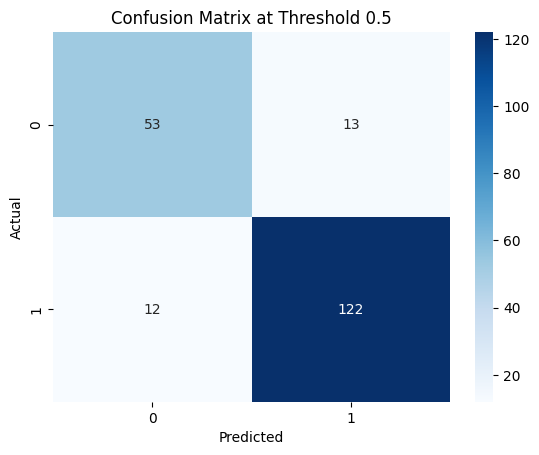

In [ ]:
def evaluate_threshold(threshold):
    preds = (probs >= threshold).astype(int)
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix at Threshold {threshold}")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Try different thresholds: 0.2 (Aggressive) vs 0.8 (Conservative)
evaluate_threshold(0.5)

# 5. Additional questions

Run the classification_report for the default threshold.

If the cost of losing a customer is high, should you lower or raise the threshold?

Adjust the threshold to 0.3 and observe the change in 'Recall' for the churn class.

**Reasoning**:
To generate the classification report for the default threshold, I need to get the predictions from the logistic regression model using `predict()` and then apply `classification_report`.



In [ ]:
y_pred_default = log_reg.predict(X_test_scaled)
print("Classification Report at Default Threshold (0.5):")
print(classification_report(y_test, y_pred_default))

Classification Report at Default Threshold (0.5):
              precision    recall  f1-score   support

           0       0.82      0.80      0.81        66
           1       0.90      0.91      0.91       134

    accuracy                           0.88       200
   macro avg       0.86      0.86      0.86       200
weighted avg       0.87      0.88      0.87       200



## Explain Threshold Adjustment for High Cost of False Negatives

If the cost of losing a customer (a false negative, where the model predicts no churn but the customer actually churns) is high, you should **lower the decision threshold**.

**Explanation:**
*   **False Negatives (FN):** These occur when the model predicts class 0 (no churn) but the actual class is 1 (churn). In the context of customer churn, a false negative means you incorrectly predict a customer won't churn, and thus, you don't intervene, leading to the loss of a valuable customer.
*   **Lowering the Threshold:** By lowering the threshold (e.g., from 0.5 to 0.3), you make it easier for the model to classify an instance as the positive class (churn). This means that even if the model predicts a churn probability of, say, 0.35, it will now be classified as churn, whereas with a 0.5 threshold, it would have been classified as no churn.
*   **Impact on Metrics:**
    *   **Recall (Sensitivity):** Lowering the threshold will generally **increase recall** for the positive class (churn). Recall is the proportion of actual churners that were correctly identified. By making it easier to predict churn, you will capture more of the true churners, thus reducing false negatives.
    *   **Precision:** However, increasing recall often comes at the cost of **decreasing precision**. Precision is the proportion of predicted churners that were actually churners. By predicting more customers as churners (due to the lower threshold), you are likely to include more false positives (customers predicted to churn who actually don't), which lowers precision.

**Trade-off:** In situations where the cost of a false negative (losing a customer) is significantly higher than the cost of a false positive (unnecessarily offering an incentive to a customer who wouldn't have churned anyway), prioritizing recall by lowering the threshold is often the preferred strategy. This ensures that fewer high-cost churn events are missed, even if it means a higher number of incorrect churn predictions (false positives).

**Reasoning**:
Now I will adjust the threshold to 0.3, generate new predictions, and then display the classification report to observe the change in recall for the churn class, as requested by the subtask.



In [ ]:
threshold = 0.3
y_pred_adjusted = (probs >= threshold).astype(int)

print(f"Classification Report at Adjusted Threshold ({threshold}):")
print(classification_report(y_test, y_pred_adjusted))

Classification Report at Adjusted Threshold (0.3):
              precision    recall  f1-score   support

           0       0.93      0.64      0.76        66
           1       0.85      0.98      0.91       134

    accuracy                           0.86       200
   macro avg       0.89      0.81      0.83       200
weighted avg       0.87      0.86      0.86       200



## Summary of Threshold Impact on Model Performance

Comparing the classification reports for the default threshold (0.5) and the adjusted threshold (0.3):

**Default Threshold (0.5):**
*   **Class 0 (No Churn):** Precision: 0.82, Recall: 0.80
*   **Class 1 (Churn):** Precision: 0.90, Recall: 0.91
*   **Overall Accuracy:** 0.88

**Adjusted Threshold (0.3):**
*   **Class 0 (No Churn):** Precision: 0.93, Recall: 0.64
*   **Class 1 (Churn):** Precision: 0.85, Recall: 0.98
*   **Overall Accuracy:** 0.86

**Key Observations:**

1.  **Recall for Churn (Class 1):** As anticipated, lowering the threshold from 0.5 to 0.3 significantly **increased the recall for the churn class (class 1)** from 0.91 to 0.98. This means the model is now much better at identifying actual churners, reducing the number of false negatives (missed churners).

2.  **Precision for Churn (Class 1):** This increase in recall for class 1 came at the cost of its **precision**, which decreased from 0.90 to 0.85. This implies that while more churners are correctly identified, a higher proportion of customers predicted to churn (false positives) actually do not churn.

3.  **Impact on Class 0 (No Churn):** Conversely, for the 'no churn' class (class 0), recall decreased from 0.80 to 0.64, while precision increased from 0.82 to 0.93. This is consistent with the trade-off, as more instances are now being classified as churn, leading to fewer correct 'no churn' predictions (lower recall for class 0) but making the 'no churn' predictions themselves more accurate (higher precision for class 0).

4.  **Overall Accuracy:** The overall accuracy slightly decreased from 0.88 to 0.86. This demonstrates that optimizing for a specific metric (like recall for a high-cost class) might lead to a small reduction in overall accuracy, which can be an acceptable trade-off given the business context (high cost of false negatives).

In summary, lowering the decision threshold to 0.3 successfully prioritized identifying churners (increased recall for class 1) at the expense of precision for the churn class and overall accuracy. This adjustment is beneficial when the business cost associated with missing a churner (false negative) is higher than the cost of incorrectly predicting a churner (false positive).

# 1. Setup: Visualizing the Margin

We will use the Breast Cancer dataset but only use two features for visualization purposes.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Load data
cancer = datasets.load_breast_cancer()
# Use only 'mean radius' and 'mean texture'
X = cancer.data[:, :2]
y = cancer.target

# Scaling is CRITICAL for SVM
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### 2. Linear SVM and the C parameter
The C parameter controls the "soft margin."

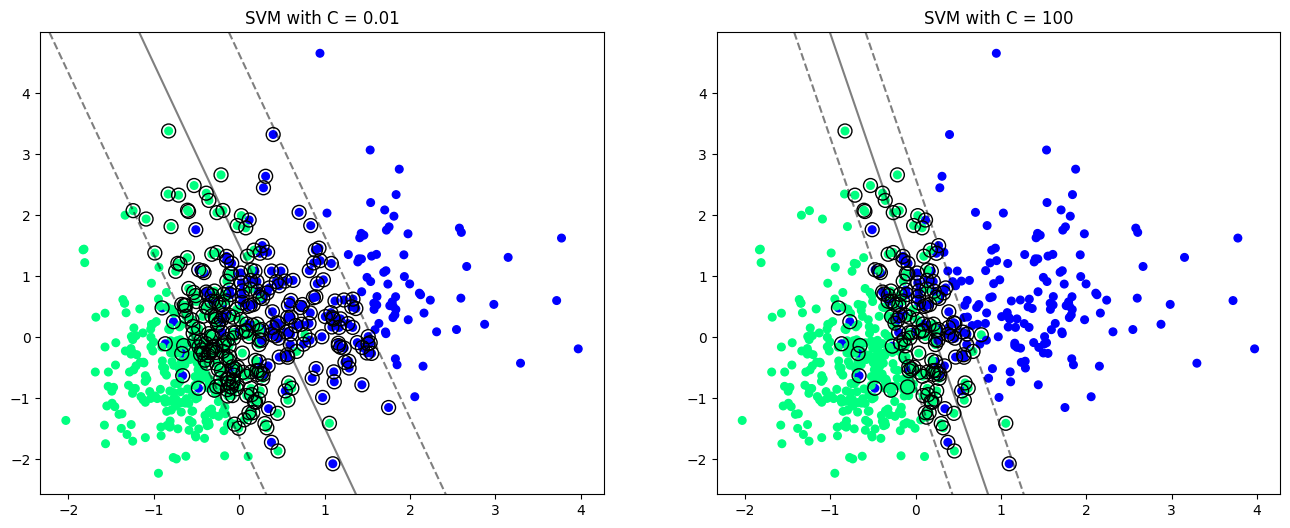

In [8]:
def plot_svc_decision_boundary(model, ax=None):
    if ax is None: ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # Create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = model.decision_function(xy).reshape(XX.shape)

    # Plot decision boundary and margins
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
    # Highlight support vectors
    ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100, linewidth=1, facecolors='none', edgecolors='k')

# Comparison
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

for i, C_val in enumerate([0.01, 100]):
    model = SVC(kernel='linear', C=C_val).fit(X_scaled, y)
    ax[i].scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, s=30, cmap='winter')
    plot_svc_decision_boundary(model, ax[i])
    ax[i].set_title(f"SVM with C = {C_val}")

plt.show()

# 3. The kernel trick (non-linear)

We'll switch to the RBF (Gaussian) kernel to see how it creates non-linear boundaries.

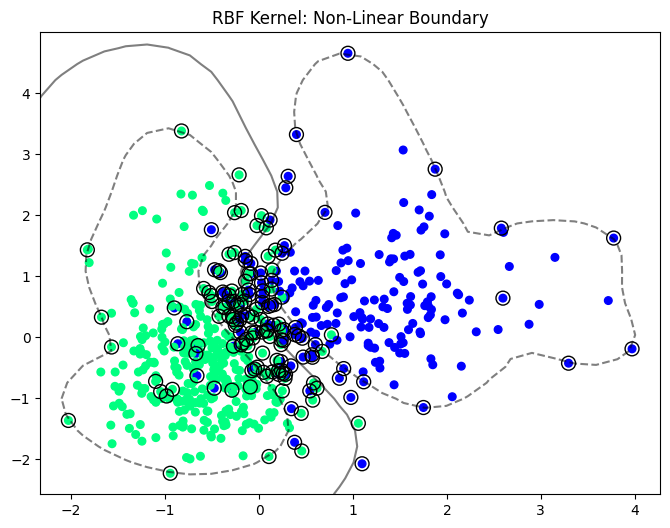

In [9]:
# Train RBF kernel SVM
rbf_model = SVC(kernel='rbf', C=1, gamma=0.7)
rbf_model.fit(X_scaled, y)

plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, s=30, cmap='winter')
plot_svc_decision_boundary(rbf_model)
plt.title("RBF Kernel: Non-Linear Boundary")
plt.show()

## Modify RBF SVM with gamma=10

Subtask:
Create a new RBF SVM model with gamma=10 and C=1 and visualize its decision boundary.

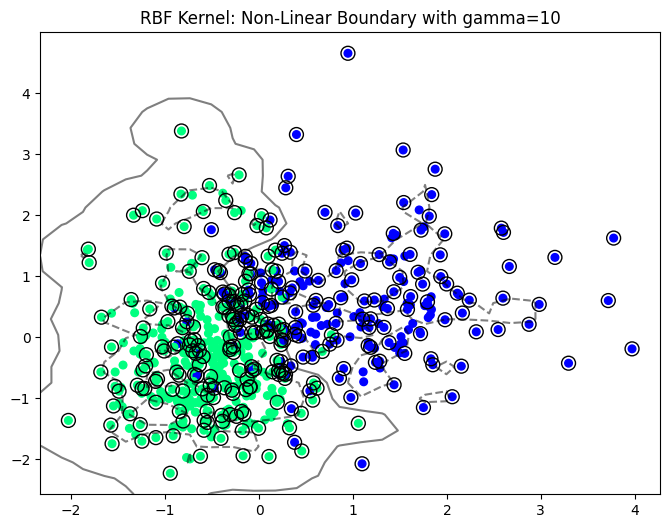

In [10]:
rbf_model_gamma10 = SVC(kernel='rbf', C=1, gamma=10)
rbf_model_gamma10.fit(X_scaled, y)

plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, s=30, cmap='winter')
plot_svc_decision_boundary(rbf_model_gamma10)
plt.title("RBF Kernel: Non-Linear Boundary with gamma=10")
plt.show()

In [11]:
from sklearn.metrics import accuracy_score

# Create a Linear SVM model with C=100
linear_model_C100 = SVC(kernel='linear', C=100)

# Fit the model to the scaled data
linear_model_C100.fit(X_scaled, y)

# Predict on the scaled data
y_pred_linear_C100 = linear_model_C100.predict(X_scaled)

# Calculate accuracy
accuracy_linear_C100 = accuracy_score(y, y_pred_linear_C100)

print(f"Accuracy of Linear SVM (C=100): {accuracy_linear_C100:.4f}")

Accuracy of Linear SVM (C=100): 0.8910


In [12]:
from sklearn.metrics import accuracy_score

# Calculate accuracy for RBF SVM with C=1, gamma=0.7
y_pred_rbf_gamma07 = rbf_model.predict(X_scaled)
accuracy_rbf_gamma07 = accuracy_score(y, y_pred_rbf_gamma07)

# Calculate accuracy for RBF SVM with C=1, gamma=10
y_pred_rbf_gamma10 = rbf_model_gamma10.predict(X_scaled)
accuracy_rbf_gamma10 = accuracy_score(y, y_pred_rbf_gamma10)

print(f"Accuracy of RBF SVM (C=1, gamma=0.7): {accuracy_rbf_gamma07:.4f}")
print(f"Accuracy of RBF SVM (C=1, gamma=10): {accuracy_rbf_gamma10:.4f}")

Accuracy of RBF SVM (C=1, gamma=0.7): 0.9104
Accuracy of RBF SVM (C=1, gamma=10): 0.9104
